<a href="https://colab.research.google.com/github/BrunoBVR/DL-with-python/blob/main/5p3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a convnet from scratch on a small dataset

Classifying Dogs vs. Cats images.

---

# Using a pretrained convnet

## Feature extraction

> Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

## Using the **VGG16** model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                  include_top = False,  # Using the base
                  input_shape = (150, 150, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


* *weights* specifies the weight checkpoint from which to initialize the model.
* *include_top* refers to including (or not) the densely connected classifier on top of the network. By default, this densely connected classifier corresponds to the 1,000 classes from ImageNet. Because you intend to use your own densely connected classifier (with only two classes: cat and dog ), you don’t need to include it.
*  *input_shape* is the shape of the image tensors that you’ll feed to the network. This argument is purely optional: if you don’t pass it, the network will be able to
process inputs of any size.

In [4]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## FAST FEATURE EXTRACTION WITHOUT DATA AUGMENTATION

Recording the output of `conv_base` on your data and using these outputs as inputs to a new model.

In [5]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = '/content/drive/MyDrive/DL-With-Python/Chapter5/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(
    directory,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary')
  i = 0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      break
  return features, labels
  
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


The extracted features are currently of shape (samples, 4, 4, 512) . You’ll feed them to a densely connected classifier, so first you must flatten them to (samples, 8192) :

In [6]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

### Defining and training the densely connected classifier

In [7]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 1s 7ms/step - loss: 0.5942 - acc: 0.6815 - val_loss: 0.4387 - val_acc: 0.8440
Epoch 2/30
100/100 [==============================] - 1s 6ms/step - loss: 0.4225 - acc: 0.8150 - val_loss: 0.3630 - val_acc: 0.8650
Epoch 3/30
100/100 [==============================] - 1s 6ms/step - loss: 0.3628 - acc: 0.8545 - val_loss: 0.3208 - val_acc: 0.8790
Epoch 4/30
100/100 [==============================] - 1s 6ms/step - loss: 0.3150 - acc: 0.8670 - val_loss: 0.3067 - val_acc: 0.8730
Epoch 5/30
100/100 [==============================] - 1s 5ms/step - loss: 0.2856 - acc: 0.8890 - val_loss: 0.2840 - val_acc: 0.8810
Epoch 6/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2696 - acc: 0.8970 - val_loss: 0.2771 - val_acc: 0.8890
Epoch 7/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2484 - acc: 0.9030 - val_loss: 0.2645 - val_acc: 0.8950
Epoch 8/30
100/100 [==============================] - 1s 6ms/step - loss: 0.

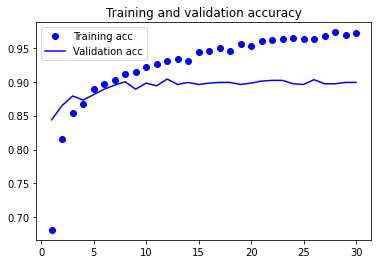

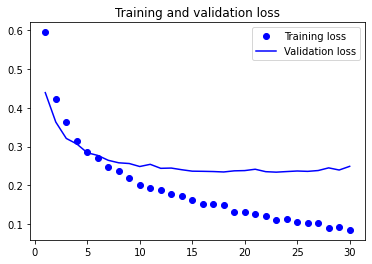

In [8]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Data Augmentation and Fine tuning

The steps for fine-tuning a network are as follow:

1. Add your custom network on top of an already-trained base network.
2. Freeze the base network.
3. Train the part you added.
4. Unfreeze some layers in the base network.
5. Jointly train both these layers and the part you added.

---

First, let's build the whole model for end-to-end classification:

In [16]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Before we compile and train the model, it's very important to freeze the convolutional base. Freezing a layer or set of layers means preventing their weights from being updated during training. If you don't do this, then the representations that were previously learned by the convolutional base will be modified during training. Because the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In [17]:
print('This is the number of trainable weights '
'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 10


In [18]:
conv_base.trainable = False

In [19]:
print('This is the number of trainable weights '
'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


Creating generators for data augmentation:

In [20]:
train_datagen = ImageDataGenerator(
                      rescale=1./255,
                      rotation_range=40,
                      width_shift_range=0.2,
                      height_shift_range=0.2,
                      shear_range=0.2,
                      zoom_range=0.2,
                      horizontal_flip=True,
                      fill_mode='nearest')
# Note that the validation data shouldn’t be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                      train_dir,
                      target_size=(150, 150),
                      batch_size=20,
                      class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
                      validation_dir,
                      target_size=(150, 150),
                      batch_size=20,
                      class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [21]:
# Compiling and fitting
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

history = model.fit(
              train_generator,
              steps_per_epoch=2000//20,
              epochs=30,
              validation_data=validation_generator,
              validation_steps=1000//20)

Epoch 1/30
100/100 [==============================] - 31s 300ms/step - loss: 0.5893 - acc: 0.6960 - val_loss: 0.4475 - val_acc: 0.8170
Epoch 2/30
100/100 [==============================] - 30s 295ms/step - loss: 0.4766 - acc: 0.7810 - val_loss: 0.3724 - val_acc: 0.8500
Epoch 3/30
100/100 [==============================] - 29s 294ms/step - loss: 0.4334 - acc: 0.8020 - val_loss: 0.3297 - val_acc: 0.8700
Epoch 4/30
100/100 [==============================] - 30s 296ms/step - loss: 0.4070 - acc: 0.8210 - val_loss: 0.3094 - val_acc: 0.8760
Epoch 5/30
100/100 [==============================] - 29s 294ms/step - loss: 0.3865 - acc: 0.8275 - val_loss: 0.2951 - val_acc: 0.8780
Epoch 6/30
100/100 [==============================] - 30s 296ms/step - loss: 0.3691 - acc: 0.8310 - val_loss: 0.2833 - val_acc: 0.8900
Epoch 7/30
100/100 [==============================] - 29s 293ms/step - loss: 0.3572 - acc: 0.8380 - val_loss: 0.2829 - val_acc: 0.8810
Epoch 8/30
100/100 [==============================] - 2

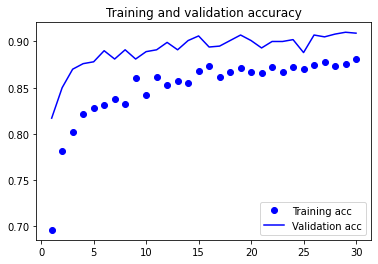

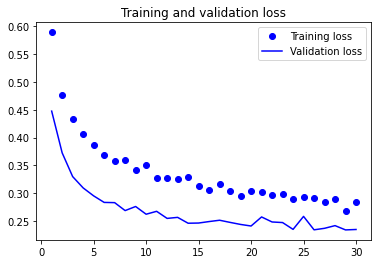

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

We'll fine-tune the last three convolutional layers, which means all layers up to *block4_pool* should be frozen, and the layers *block5_conv1* , *block5_conv2*, and *block5_conv3* should be trainable.

In [24]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

Now we can begin fine-tuning the network. We'll do this with the RMSProp optimizer, using a very low learning rate. The reason for using a low learning rate is that you want to limit the magnitude of the modifications you make to the representations of the three layers we're fine-tuning. Updates that are too large may harm these representations.

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [26]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['acc'])

history = model.fit(
    train_generator,
    steps_per_epoch = 2000//20,
    epochs = 100,
    validation_data = validation_generator,
    validation_steps = 1000//20
)

Epoch 1/100
100/100 [==============================] - 33s 304ms/step - loss: 0.2911 - acc: 0.8785 - val_loss: 0.2219 - val_acc: 0.9050
Epoch 2/100
100/100 [==============================] - 30s 305ms/step - loss: 0.2555 - acc: 0.8890 - val_loss: 0.2140 - val_acc: 0.9110
Epoch 3/100
100/100 [==============================] - 30s 304ms/step - loss: 0.2374 - acc: 0.9010 - val_loss: 0.2490 - val_acc: 0.9040
Epoch 4/100
100/100 [==============================] - 31s 307ms/step - loss: 0.2144 - acc: 0.9115 - val_loss: 0.2176 - val_acc: 0.9170
Epoch 5/100
100/100 [==============================] - 30s 302ms/step - loss: 0.2044 - acc: 0.9175 - val_loss: 0.1859 - val_acc: 0.9240
Epoch 6/100
100/100 [==============================] - 30s 304ms/step - loss: 0.2062 - acc: 0.9175 - val_loss: 0.1968 - val_acc: 0.9140
Epoch 7/100
100/100 [==============================] - 30s 303ms/step - loss: 0.1806 - acc: 0.9250 - val_loss: 0.1884 - val_acc: 0.9260
Epoch 8/100
100/100 [===========================

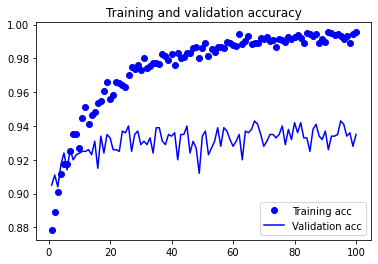

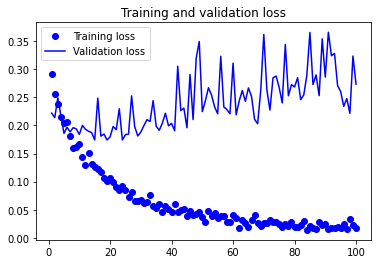

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

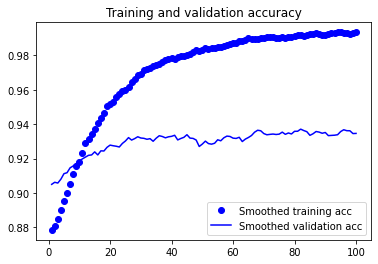

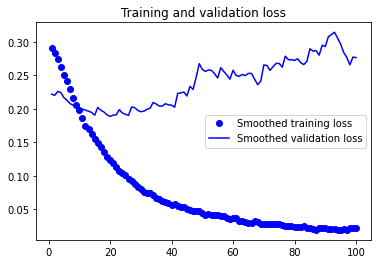

In [28]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [29]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


test acc: 0.9409999847412109
